# 0. Imports

In [123]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 0.1 Accessibility

In [124]:
colorVisionDeficiencyMode = False

# 1. Helper Classes

## 1.1 Perlin Noise

In [125]:
# Perline noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v)

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

if __name__ == 'main':
    lin = np.linspace(0,5,100,endpoint=False)
    x,y = np.meshgrid(lin,lin)

    plt.imshow(perlin(x,y,seed=5),origin='upper')
    plt.show()

## 1.2 Point

In [126]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.comparator = math.inf

	def __lt__(self, other):
		return self.comparator < other.comparator

	def __gt__(self, other):
		return self.comparator > other.comparator

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map

In [127]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, cost_function='exp',seed=None,
	             filename=None, start=None, goal=None):

		self.seed = seed
		if self.seed == None:
			# Randomly assign seed from 0 to 10k if not provided
			self.seed = randint(0,10000)
		self.length = length
		self.width = width
		self.generateTerrain(filename)
		self.explored = []
		self.explored_lookup = {}
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5))
		else:
			self.start = Point(start[0], start[1])
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9))
		else:
			self.goal = Point(goal[0], goal[1])
		if cost_function == 'exp':
			self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
		elif cost_function == 'div':
			self.cost_function = lambda h0, h1: h0/(h1+1)
		self.cmap = mpl.colors.ListedColormap(['white', 'red'])
		if colorVisionDeficiencyMode:
			self.cmap = mpl.colors.ListedColormap(['white', 'magenta'])

	'''generateTerrain: modifes self.map to either be the specified file, or
	randomly generated from perlin noise.
	input:
	filename - str, string of the npy file to generate the map
	seed - int, integer for reproducibility of a particular map
	octaves - int parameter for perlin noise
	output:
	None, self.map modified'''
	def generateTerrain(self, filename=None):
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (0.0 > w):
			return a0
		if (1.0 < w):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculatePathCost(self, path):
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.isAdjacent(prev, item):
				cost += self.getCost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def validTile(self, x, y):
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	'''def validTile(self, p1):
		return self.validTile(p1.x, p1.y)'''

	def getTile(self, x, y):
		return self.map[x][y]

	'''def getTile(self, p1):
		return self.getTile(p1.x, p1.y)'''

	def getCost(self, p1, p2):
		h0 = self.getTile(p1.x, p1.y)
		h1 = self.getTile(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def isAdjacent(self, p1, p2):
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def getNeighbors(self, p1):
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.validTile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
		return neighbors

	def getStartPoint(self):
		return self.start

	def getEndPoint(self):
		return self.goal

	def getHeight(self):
		return np.amax(self.map)

	'''Creates a 2D image of the path taken and nodes explroed, prints
	pathcost and number of nodes explored'''
	def createImage(self, path):
		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculatePathCost(path))
		print('Nodes explored: ', len(self.explored) + len(path))
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=self.cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, color='blue', linewidth=1)
		plt.show()

	'''Set the start and goal point on the 2D map, each point is a pair of integers'''
	def setStartGoal(self, start, goal):
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

# 2. AI Modules

You'll write your code here!

## 2.1 AI Module & Dijkstras

In [128]:
'''AIModule Interface
createPath(map map_) -> list<points>: Adds points to a path'''
class AIModule:

	def createPath(self, map_):
		pass

'''
A sample AI that takes a very suboptimal path.
This is a sample AI that moves as far horizontally as necessary to reach
the target, then as far vertically as necessary to reach the target.
It is intended primarily as a demonstration of the various pieces of the
program.
'''
class StupidAI(AIModule):

	def createPath(self, map_):
		path = []
		explored = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def createPath(self, map_):
		q = PriorityQueue()
		''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		node), previous (node -> parent). This keeps track of paths, and explored
		which helps us run faster by ignoring nodes already visited'''
		cost = {}
		prev = {}
		explored = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost[(i,j)] = math.inf
				prev[(i,j)] = None
				explored[(i,j)] = False
		current_point = deepcopy(map_.start)
		current_point.comparator = 0
		cost[(current_point.x, current_point.y)] = 0
		# Add start node to the queue
		q.put(current_point)
		# Search loop
		while q.qsize() > 0:
			# Get new point from PQ
			v = q.get()
			if explored[(v.x,v.y)]:
				continue
			explored[(v.x,v.y)] = True
			# Check if popping off goal
			if v == map_.getEndPoint():
				break
			# Evaluate neighbors
			neighbors = map_.getNeighbors(v)
			for neighbor in neighbors:
				alt = map_.getCost(v, neighbor) + cost[(v.x,v.y)]
				if alt < cost[(neighbor.x,neighbor.y)]:
					cost[(neighbor.x,neighbor.y)] = alt
					neighbor.comparator = alt
					prev[(neighbor.x,neighbor.y)] = v
				q.put(neighbor)
		# Find and return path
		path = []
		while v != map_.getStartPoint():
			path.append(v)
			v = prev[(v.x,v.y)]
		path.append(map_.getStartPoint())
		path.reverse()
		return path

## 2.2 AIExp and AIMSH
Here, specifically

In [129]:
class AStarExp(AIModule):

    def heuristic(self, map_, current_point, goal_point):
        x_distance, y_distance = self._calculate_distances(current_point, goal_point)
        current_height, goal_height = self._get_heights(map_, current_point, goal_point)

        height_difference = goal_height - current_height
        max_distance = max(x_distance, y_distance)

        return self._calculate_heuristic(height_difference, max_distance)

    def _calculate_distances(self, point1, point2):
        x_distance = abs(point1.x - point2.x)
        y_distance = abs(point1.y - point2.y)
        return x_distance, y_distance

    def _get_heights(self, map_, point1, point2):
        height1 = map_.getTile(point1.x, point1.y)
        height2 = map_.getTile(point2.x, point2.y)
        return height1, height2

    def _calculate_heuristic(self, height_difference, max_distance):
        return height_difference * math.exp(1) + (max_distance - height_difference)

    def createPath(self, map_):
        q = PriorityQueue()
        cost = {}
        prev = {}
        explored = {}

        for i in range(map_.width):
            for j in range(map_.length):
                cost[(i, j)] = math.inf
                prev[(i, j)] = None
                explored[(i, j)] = False

        current_point = deepcopy(map_.start)
        current_point.comparator = 0
        cost[(current_point.x, current_point.y)] = 0
        q.put(current_point)

        while q.qsize() > 0:
            v = q.get()
            if explored[(v.x, v.y)]:
                continue
            explored[(v.x, v.y)] = True

            if v == map_.getEndPoint():
                break

            for neighbor in map_.getNeighbors(v):
                new_cost = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
                estimated_total_cost = new_cost + self.heuristic(map_, neighbor, map_.getEndPoint())

                if new_cost < cost[(neighbor.x, neighbor.y)]:
                    cost[(neighbor.x, neighbor.y)] = new_cost
                    prev[(neighbor.x, neighbor.y)] = v
                    neighbor.comparator = estimated_total_cost

                q.put(neighbor)

        path = []
        while v != map_.getStartPoint():
            path.append(v)
            v = prev[(v.x, v.y)]
        path.append(map_.getStartPoint())
        path.reverse()
        return path


class AStarDiv(AIModule):

    def heuristic(self, map_, current_point, goal_point):
        x_distance, y_distance = self._calculate_manhattan_distance(current_point, goal_point)
        height_cost = self._calculate_height_cost(map_, current_point, goal_point)

        return height_cost + max(x_distance, y_distance)

    def _calculate_manhattan_distance(self, point1, point2):
        x_distance = abs(point1.x - point2.x)
        y_distance = abs(point1.y - point2.y)
        return x_distance, y_distance

    def _calculate_height_cost(self, map_, point1, point2):
        current_height = map_.getTile(point1.x, point1.y)
        goal_height = map_.getTile(point2.x, point2.y)
        return current_height / (abs(goal_height) + 1)

    def createPath(self, map_):
        q = PriorityQueue()
        cost = {}
        prev = {}
        explored = {}

        for i in range(map_.width):
            for j in range(map_.length):
                cost[(i, j)] = math.inf
                prev[(i, j)] = None
                explored[(i, j)] = False

        current_point = deepcopy(map_.start)
        current_point.comparator = 0
        cost[(current_point.x, current_point.y)] = 0
        q.put(current_point)

        while q.qsize() > 0:
            v = q.get()
            if explored[(v.x, v.y)]:
                continue
            explored[(v.x, v.y)] = True

            if v == map_.getEndPoint():
                break

            neighbors = map_.getNeighbors(v)
            for neighbor in neighbors:
                h = self.heuristic(map_, neighbor, map_.getEndPoint())
                g = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
                f = g + h

                if g < cost[(neighbor.x, neighbor.y)]:
                    cost[(neighbor.x, neighbor.y)] = g
                    neighbor.comparator = f
                    prev[(neighbor.x, neighbor.y)] = v

                q.put(neighbor)

        path = []
        while v != map_.getStartPoint():
            path.append(v)
            v = prev[(v.x, v.y)]
        path.append(map_.getStartPoint())
        path.reverse()
        return path


class AStarMSH(AIModule):

    def heuristic(self, map_, current_point, goal_point):
        x_distance, y_distance = self._calculate_distances(current_point, goal_point)
        current_height, goal_height = self._get_heights(map_, current_point, goal_point)

        height_difference = goal_height - current_height
        max_distance = max(x_distance, y_distance)

        return self._calculate_heuristic(height_difference, max_distance)

    def _calculate_distances(self, point1, point2):
        x_distance = abs(point1.x - point2.x)
        y_distance = abs(point1.y - point2.y)
        return x_distance, y_distance

    def _get_heights(self, map_, point1, point2):
        height1 = map_.getTile(point1.x, point1.y)
        height2 = map_.getTile(point2.x, point2.y)
        return height1, height2

    def _calculate_heuristic(self, height_difference, max_distance):
        return height_difference * math.exp(1) + (max_distance - height_difference)

    def createPath(self, map_):
        BEAM_WIDTH = 10  # Set the beam width
        q = PriorityQueue()
        cost = {}
        prev = {}
        explored = {}

        for i in range(map_.width):
            for j in range(map_.length):
                cost[(i, j)] = math.inf
                prev[(i, j)] = None
                explored[(i, j)] = False

        current_point = deepcopy(map_.start)
        current_point.comparator = 0
        cost[(current_point.x, current_point.y)] = 0
        q.put((0, current_point))  # Queue stores a tuple of (f, node)

        while not q.empty():
            _, v = q.get()
            if explored[(v.x, v.y)]:
                continue
            explored[(v.x, v.y)] = True

            if v == map_.getEndPoint():
                break

            next_nodes = []
            for neighbor in map_.getNeighbors(v):
                g = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
                h = self.heuristic(map_, neighbor, map_.getEndPoint())
                f = g + h

                if g < cost[(neighbor.x, neighbor.y)]:
                    cost[(neighbor.x, neighbor.y)] = g
                    neighbor.comparator = f
                    prev[(neighbor.x, neighbor.y)] = v
                    next_nodes.append((f, neighbor))

            # Implementing Beam Width: Keep only BEAM_WIDTH number of nodes in the queue
            next_nodes.sort(key=lambda x: x[0])  # Sort by f value
            for node in next_nodes[:BEAM_WIDTH]:
                q.put(node)

        path = []
        while v != map_.getStartPoint():
            path.append(v)
            v = prev[(v.x, v.y)]
        path.append(map_.getStartPoint())
        path.reverse()
        return path

# 3. Run

## 3.1 Setup

w(int): Width of map

l(int): Length of map

start(array-like<int>): Start position

goal(array-like<int>): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarDiv, AStarMSH, Djikstras

filename(string): Filepath for .npy file to be used for map

In [130]:
w = 500
l = 500
start = None
goal = None
seed = 0
cost_function = 'exp'
#cost_function = 'div'
AI = AStarExp() # Dijikstras() before
filename = None

## 3.2 Run

Time (s):  3.996370792388916
Path cost: 241.55253710831192
Nodes explored:  32133


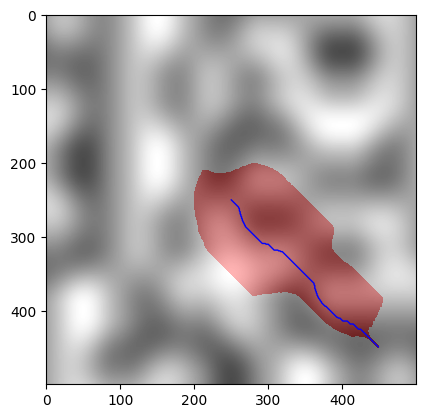

In [131]:
m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

# 4. Tests

## 4.1 AStarExp

In [132]:
cost_function = 'exp'

Time (s):  4.270376205444336
Path cost: 241.55253710831192
Nodes explored:  32133


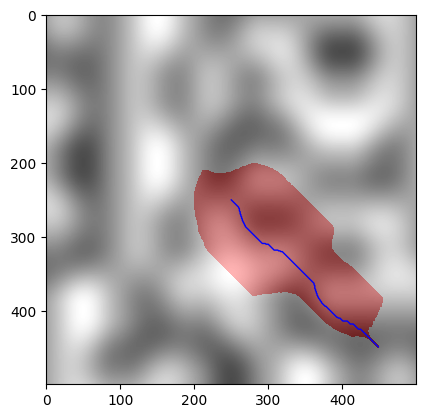

In [133]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarExp() after implemented
AI = AStarExp() # Dijikstras() before
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  5.99741268157959
Path cost: 238.5060683830129
Nodes explored:  25835


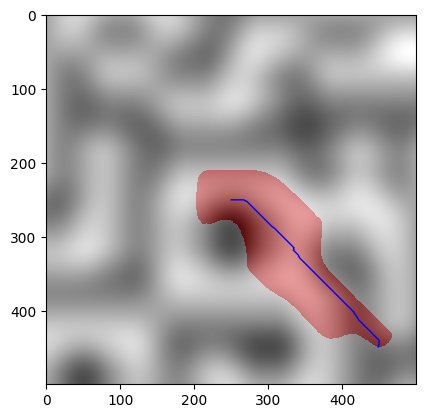

In [134]:
seed = 1

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  2.928853988647461
Path cost: 236.667690049357
Nodes explored:  25371


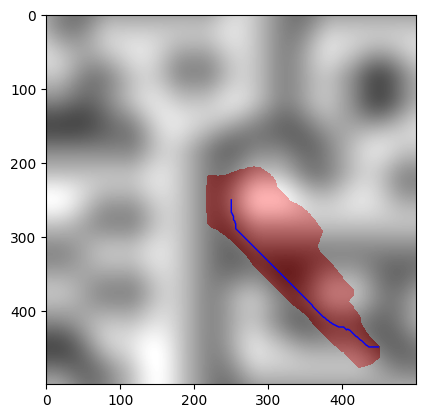

In [135]:
seed = 2

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  1.5763535499572754
Path cost: 422.01798243905006
Nodes explored:  13192


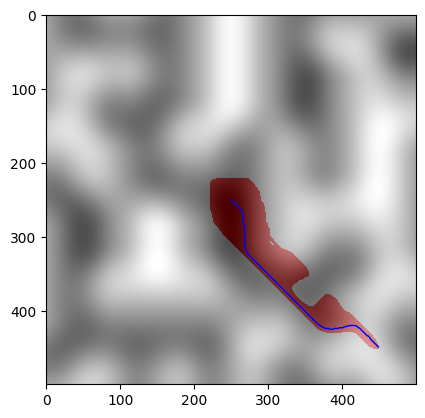

In [136]:
seed = 3

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  1.592426061630249
Path cost: 254.34464507852198
Nodes explored:  13574


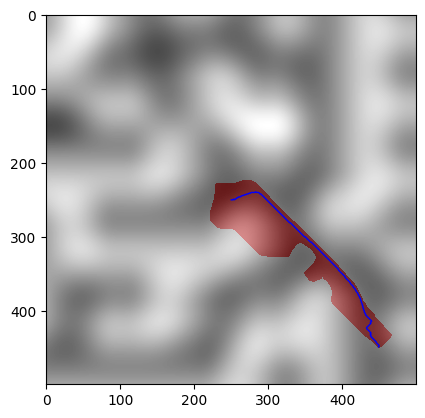

In [137]:
seed = 4

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.1 AStarDiv

In [138]:
cost_function = 'div'

Time (s):  0.29874110221862793
Path cost: 197.67690128917357
Nodes explored:  1199


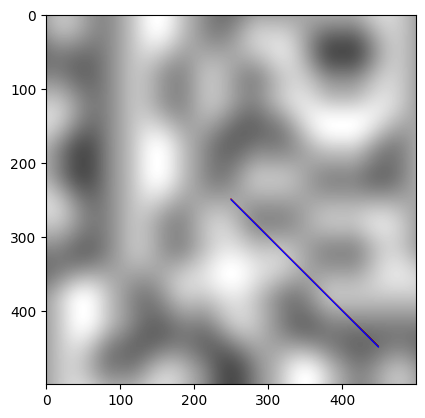

In [139]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarDiv() after implemented
AI = AStarDiv() # Dijikstras() before
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.26784300804138184
Path cost: 197.71721595331226
Nodes explored:  1199


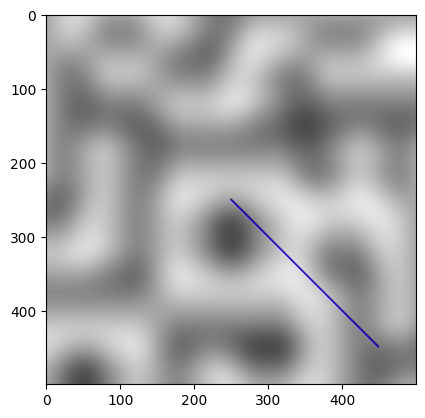

In [140]:
seed = 1

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.30867671966552734
Path cost: 197.58110211547168
Nodes explored:  1199


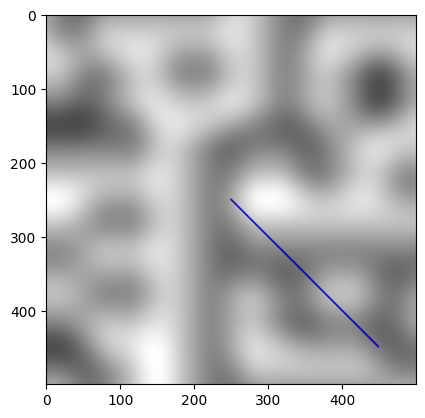

In [141]:
seed = 2

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.3025088310241699
Path cost: 196.29556836229682
Nodes explored:  1199


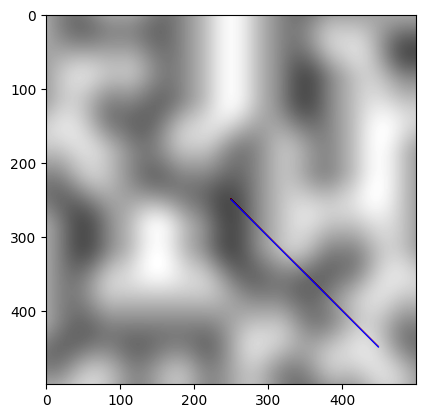

In [142]:
seed = 3

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.43282651901245117
Path cost: 197.24829713437708
Nodes explored:  1199


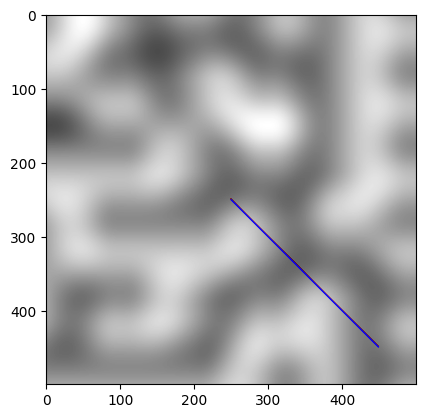

In [143]:
seed = 4

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.2 MSH

Time (s):  16.367264986038208
Path cost: 515.2967010603603
Nodes explored:  196552


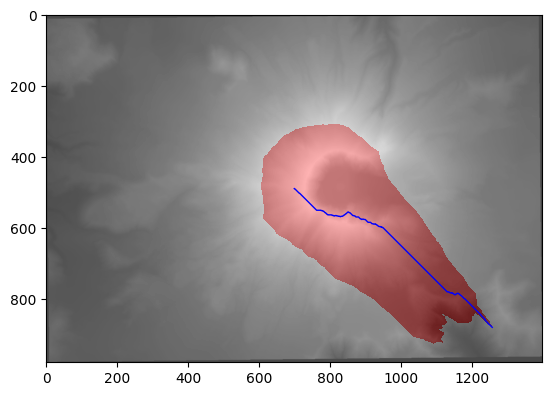

In [122]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarMSH() after implemented
AI = AStarMSH()
# Change to the filepath on your drive
filename = "/content/gdrive/My Drive/msh.npy"

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)